# MNIST compression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

In [5]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.decomposition import PCA

X = X_train

pca = PCA()
pca.fit(X)
d = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
d

154

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
pca.n_components_

154

In [8]:
np.sum(pca.explained_variance_ratio_)

0.95043464658515875

In [9]:
X_mnist = X_train

pca = PCA(n_components = 154)
X_mnist_reduced = pca.fit_transform(X_mnist)
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced)

In [12]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.matplotlib.cm.binary, **options)
    plt.axis("off")

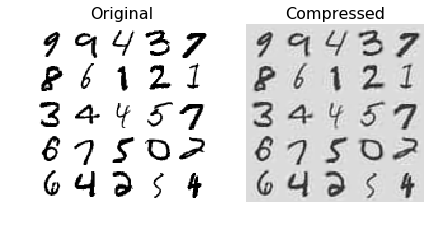

In [13]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_mnist_recovered[::2100])
plt.title("Compressed", fontsize=16)

### MNIST_compression_plot

In [14]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_mnist, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_mnist_reduced_inc = inc_pca.transform(X_mnist)

....................................................................................................

In [15]:
X_mnist_recovered_inc = inc_pca.inverse_transform(X_mnist_reduced_inc)

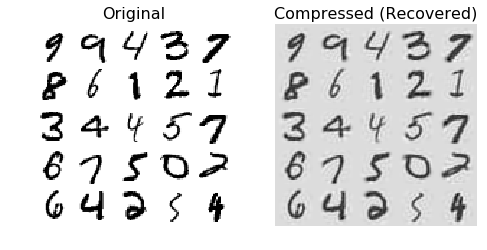

In [17]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_mnist_recovered_inc[::2100])
plt.title("Compressed (Recovered)", fontsize=16)
plt.tight_layout()

In [18]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [20]:
np.allclose(X_mnist_reduced, X_mnist_reduced_inc) 

### Checks if all the element wise values are matching

False

In [21]:
filename = "my_mnist.data"

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_mnist.shape)
X_mm[:] = X_mnist
del X_mm

In [22]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=X_mnist.shape)

batch_size = len(X_mnist) // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [23]:
rnd_pca = PCA(n_components=154, random_state=42, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_mnist)

In [24]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=154, batch_size=500)
    rnd_pca = PCA(n_components=154, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_mnist)
        t2 = time.time()
        print(pca.__class__.__name__, t2 - t1, "seconds")

n_components = 2
PCA 2.234342336654663 seconds
IncrementalPCA 33.173407554626465 seconds
PCA 8.496662139892578 seconds
n_components = 10
PCA 2.5877480506896973 seconds
IncrementalPCA 35.24949312210083 seconds
PCA 8.186444520950317 seconds
n_components = 154
PCA 8.499656915664673 seconds
IncrementalPCA 32.777132987976074 seconds
PCA 8.276491165161133 seconds


# Kernel PCA

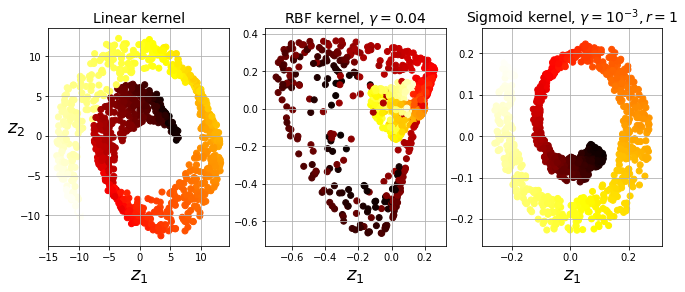

In [26]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Kernel_pca_plot

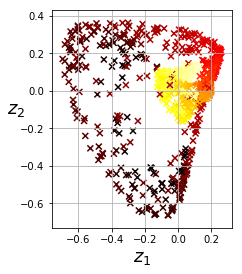

In [29]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [
        {"kpca__gamma": np.linspace(0.03, 0.05, 10), "kpca__kernel": ["rbf", "sigmoid"]}
    ]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [31]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [32]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.786308795766111

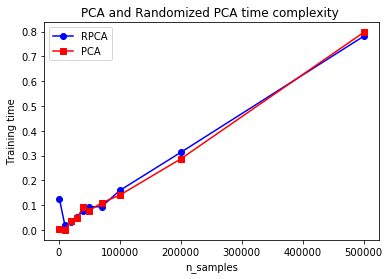

In [34]:
import numpy.random as rnd

times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = rnd.randn(n_samples, 5)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

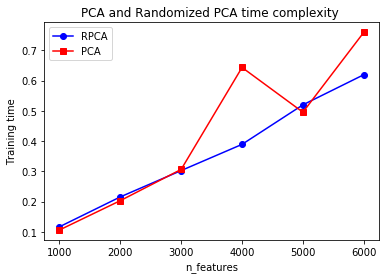

In [35]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = rnd.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Locally Linear Embedding (LLE)

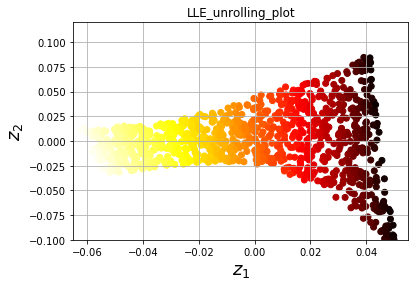

In [36]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, random_state=42)
X_reduced = lle.fit_transform(X)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.title("LLE_unrolling_plot")
plt.show()

# MDS, Isomap and t-SNE

In [37]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(X)

### Linear Discriminant Analysis

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\Lohith\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


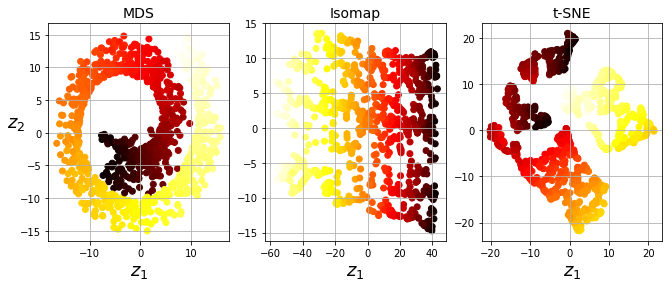

In [40]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


plt.show()

### Reduction plots